This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo

In [1]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance, mean_absolute_percentage_error
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [3]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_11-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_11-10-22.pkl'

In [4]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [5]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['dam_area'] < max_value])
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [6]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['dam_area'] < max_value])
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [7]:
training_data.shape

(108847, 36)

In [8]:
val_data.shape

(12092, 36)

In [9]:
# set a list of columns to drop, the model will not see these
drop_list = ['water_area','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [10]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['water_area']]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [11]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['water_area']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [13]:
train_X.sample(frac=.8)

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
14260,1502.175647,44.078991,18.484610,12.119053,47.806644,33.216236,105.965569,61.232395,46.262627,52.111595,...,20.653406,14.051147,12.053947,9.877105,9.996412,9.460949,13.723057,18.156710,23.725174,24.283052
109038,1409.047889,24.658129,12.145831,9.827219,4.686504,73.734207,54.600315,9.101121,45.124428,208.005569,...,10.973063,11.826035,14.414478,19.651604,22.296015,24.199566,25.173695,23.421217,25.611414,21.033312
57017,813.972101,113.048874,28.964355,2.828537,13.554602,15.765535,7.718321,29.602713,52.822086,69.517761,...,23.120157,20.435667,19.307491,17.454504,12.437448,10.953352,10.749262,11.826750,11.571700,15.777374
14706,1813.402372,52.166130,254.025345,163.992172,136.114716,52.763577,44.792336,95.640717,31.428995,174.273514,...,21.571581,17.934534,16.602638,13.713575,13.453103,14.375212,17.013697,20.281342,22.589363,23.633072
21145,919.835243,34.320545,68.400841,136.050323,41.292072,55.717686,44.441917,22.406158,163.606201,14.857530,...,20.773487,18.717936,15.702256,15.821653,15.885867,19.279404,22.213207,24.377144,25.903763,24.740734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100115,804.616386,20.808918,14.565871,26.766933,16.198702,31.705276,24.554930,32.354496,84.529404,37.562233,...,14.301478,11.306694,8.270970,7.601646,9.229594,12.450887,16.107008,21.088699,25.029554,25.351465
21910,2534.221922,26.614487,31.543283,21.657293,16.199274,35.719112,67.743927,31.566158,50.169899,53.400547,...,17.702095,9.706591,9.424479,9.309939,10.436329,12.679342,16.335836,19.881388,21.408627,21.729055
88487,695.625800,116.815010,75.353294,57.751938,31.875973,73.729301,65.242935,40.439514,48.675858,17.199783,...,24.195726,21.302879,19.450369,15.604483,11.088762,7.885047,7.092302,8.562417,11.551479,15.047509
98302,11858.693970,48.022648,28.076122,50.810242,81.398125,63.503651,56.373734,80.191795,24.123444,95.184105,...,15.574866,15.042404,13.073001,10.240356,11.035423,11.477639,14.095096,16.036488,19.342953,20.278801


In [14]:
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_11-10-22.pkl'

In [15]:
# func to train a model using variable inputs
def train_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y,verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['water_area'].to_numpy(), y_pred)
                
    return(-model_mean_error)

In [16]:
# set the bounds for optimization search
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,10)}

In [17]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [18]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -948.7    | 0.2668    | 7.483     | 10.08     |
| 2         | -368.6    | 0.2209    | 2.321     | 73.71     |
| 3         | -336.1    | 0.1745    | 4.11      | 283.8     |
| 4         | -338.3    | 0.3155    | 4.773     | 482.8     |
| 5         | -443.4    | 0.1818    | 8.903     | 28.9      |
| 6         | -342.3    | 0.3682    | 4.756     | 395.5     |
| 7         | -337.6    | 0.1562    | 2.783     | 562.5     |
| 8         | -339.5    | 0.4873    | 3.821     | 487.7     |
| 9         | -354.7    | 0.4506    | 9.051     | 68.68     |
| 10        | -337.0    | 0.1156    | 2.528     | 615.9     |
| 11        | -333.0    | 0.1393    | 4.79      | 670.9     |
| 12        | -343.1    | 0.3133    | 7.227     | 227.7     |
| 13        | -351.5    | 0.3746    | 8.512     | 22.62     |
| 14        | -417.5    | 0.4001    | 9.9       | 526.2     |
| 15    

In [22]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [19]:
def train_fin_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [20]:
model_count = 10

In [21]:
top_5_models = pd.DataFrame(optimizer.res).sort_values('target', ascending=[False]).head(model_count)
top_5_models

,target,params
10,-333.041628,"{'learning_rate': 0.13933873353322004, 'max_de..."
28,-334.366978,"{'learning_rate': 0.23702701833436968, 'max_de..."
17,-335.229664,"{'learning_rate': 0.24824168722070647, 'max_de..."
20,-335.971992,"{'learning_rate': 0.24592860570078534, 'max_de..."
2,-336.050431,"{'learning_rate': 0.17450408455106836, 'max_de..."
9,-336.965019,"{'learning_rate': 0.11562191329315295, 'max_de..."
6,-337.625215,"{'learning_rate': 0.15615477543809353, 'max_de..."
3,-338.307982,"{'learning_rate': 0.3155266936013428, 'max_dep..."
7,-339.545191,"{'learning_rate': 0.48730463028775906, 'max_de..."
14,-339.739831,"{'learning_rate': 0.2121775968257621, 'max_dep..."


In [22]:
models = []
for row, model_hyps in tqdm(top_5_models.iterrows(),total=model_count):
    models.append({'model_number':str(row),
                   'model':train_fin_model(**model_hyps['params'])})

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
preds = pd.DataFrame()
for model in models:
    y_pred = model['model'].predict(val_X)
    y_pred = y_pred*(y_pred>0)
    preds[model['model_number']] = y_pred
    

In [24]:
preds

,10,28,17,20,2,9,6,3,7,14
0,285.624878,275.431519,326.711121,305.134521,301.292114,306.310974,298.882721,299.443085,278.925781,279.569702
1,4231.017578,3909.634766,4107.833496,3876.258545,4126.704590,4155.320312,4082.592285,4396.755859,4082.105713,4298.425293
2,433.110107,457.734528,533.367188,535.484314,510.135498,560.031189,554.614624,382.366364,473.938232,609.596008
3,209.817902,215.524994,211.850784,228.974121,223.770218,233.793274,224.572449,218.497284,251.515457,221.067596
4,1073.936768,1131.490967,1086.991455,943.159607,976.700500,876.307678,880.358521,721.927979,1219.893433,1108.466797
...,...,...,...,...,...,...,...,...,...,...
12087,4025.942139,4086.768311,4370.898438,3790.739502,3999.853516,4130.614258,3869.632324,4106.176758,4306.623535,4059.108643
12088,222.744293,195.473801,213.697830,215.176071,206.675720,208.682831,194.472610,224.584564,234.071915,207.249390
12089,1068.602295,863.885925,1239.254639,1429.605591,1545.040527,1387.211182,1528.172119,962.092041,1009.834778,1320.753784
12090,1152.098389,1199.396606,1292.243286,1367.591064,1183.870361,1249.115967,1291.835449,1280.575195,1309.827759,1174.215576


In [25]:
val_y['preds'] = preds.mean(axis=1).to_list()

In [26]:
val_y

,water_area,preds
0,400.256079,295.732666
1,5781.220903,4126.665039
2,581.212166,505.037842
3,317.463008,223.938400
4,508.559500,1001.923340
...,...,...
12230,5955.113008,4074.635986
12231,106.330725,212.282913
12232,2320.997848,1235.445312
12233,1341.055972,1250.076904


In [45]:
val_y.to_csv('data/dam forecast val vs pred.csv')

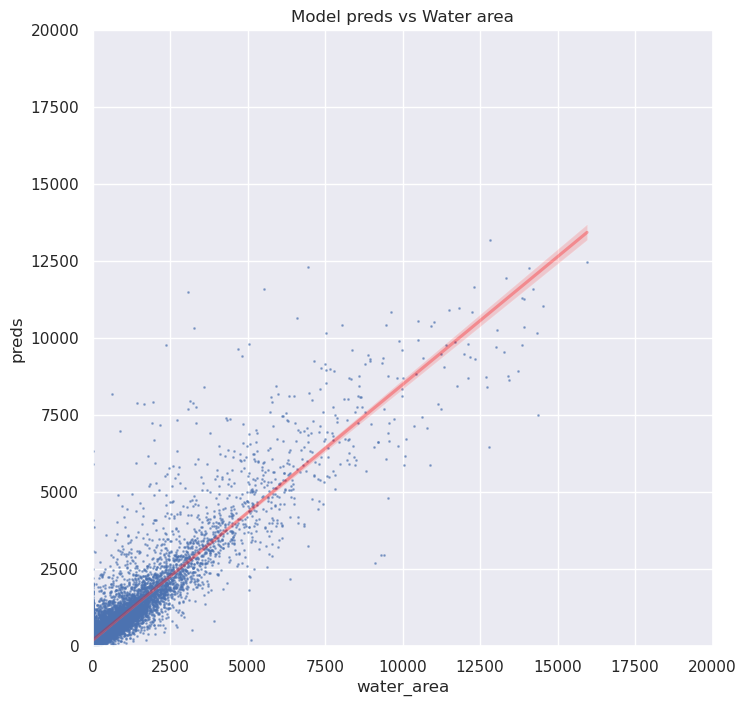

In [46]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="water_area", y="preds", data=val_y,
                 scatter_kws={'s':1, 'alpha':0.5},
                 line_kws={"color": "red",'alpha':0.3}
                )
sns.set(rc={"figure.figsize":(8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))
ax.set(title='Model preds vs Water area');

In [47]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y['water_area'], val_y['preds'], 1)
grad, y_intersect

(0.8304372607609136, 166.61233519935678)

In [48]:
# significant improvment from scaled factor above
model_mea = mean_absolute_error(val_y['water_area'], val_y['preds'])
model_mea

328.6552159549693

In [53]:
# mean model error percent
model_mea/val_y['water_area'].mean()

0.3237132836984982

In [54]:
# mape = np.mean(np.abs(val_y['water_area'] - val_y['preds'])/val_y['preds'])*100
# mape

In [55]:
model_improvment = 1-(model_mea/466.89)
print(f'the model is {round(model_improvment*100)}% better than the scaled dam area') 

the model is 30% better than the scaled dam area


In [56]:
model_improvment = 1-(model_mea/885.85)
print(f'the model is {round(model_improvment*100)}% better than always guessing water area mean') 

the model is 63% better than always guessing water area mean


In [42]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [43]:
model_path

'/home/nick/Documents/Work code/Weather-to-water/data/dam_forecast_11-10-22.pkl'